In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
%matplotlib inline


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df



In [2]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b
    
    return block_collection, block_dict

# Example usage:
animals = ['PV_126', 'PV_62']
block_lists = [[6,7, 9,10], [23,24,25,26,27]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals, 
    block_lists=block_lists, 
    experiment_path=experiment_path, 
    bad_blocks=bad_blocks
)

instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_006, new OE version
Found the sample rate for block 006 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 006
got it!
instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\exp

In [14]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
#block_numbers = [23,24,25,26,27,35,38,39,40,41]
#block_numbers = [7,8,9,10,11,13]
block_numbers = [7]
#bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
bad_blocks = [0]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_126'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!


In [15]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax 
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [10]:
# over here, I am creating the new rotation function for the eye_data dfs - this should be integrated into the blocksync class later: 
import cv2
import numpy as np
import pandas as pd

def rotate_single_eye_data(block, eye, new_rotation_angle):
    """
    Rotate the eye data for a single eye by counter-rotating the current rotation and applying an additional rotation.
    
    This function:
      1. Determines the center of the frame by reading the first frame of the corresponding eye video.
      2. Computes the net rotation as: net_rotation = new_rotation_angle - current_rotation_angle.
      3. Applies the net rotation to the 'center_x' and 'center_y' coordinates of the eye data.
      4. Updates the 'phi' (ellipse orientation) by subtracting the net rotation.
      5. Updates the BlockSync object with the newly rotated data and new rotation angle.
    
    Parameters:
        block : BlockSync object
            The BlockSync instance containing the eye data and rotation parameters.
        eye : str
            Either "left" or "right", indicating which eye's data to rotate.
        new_rotation_angle : float
            The desired new rotation angle (in degrees) after applying the transformation.
    
    Returns:
        None. The function updates the block.left_eye_data or block.right_eye_data and the corresponding rotation angle in-place.
    """
    # Select the appropriate data and video list based on the eye.
    if eye.lower() == 'left':
        eye_data = block.left_eye_data
        current_angle = block.left_rotation_angle
        video_list = block.le_videos
    elif eye.lower() == 'right':
        eye_data = block.right_eye_data
        current_angle = block.right_rotation_angle
        video_list = block.re_videos
    else:
        raise ValueError("Eye must be 'left' or 'right'")
    
    # Ensure that there is at least one video available.
    if not video_list:
        raise ValueError(f"No video available for {eye} eye.")
    
    # Open the first video to determine frame dimensions and compute the center.
    video_path = video_list[0]
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    center = (frame_width / 2, frame_height / 2)
    cap.release()
    
    # Compute the net rotation angle: first counter-rotate (undo current) then apply new rotation.
    net_rotation = new_rotation_angle - current_angle
    
    # Compute the affine transformation matrix for the net rotation.
    M = cv2.getRotationMatrix2D(center, net_rotation, 1.0)
    
    # Extract (center_x, center_y) from the DataFrame and convert to float32.
    coords = eye_data[['center_x', 'center_y']].values.astype(np.float32)
    # Convert coordinates to homogeneous form by adding a column of ones.
    ones = np.ones((coords.shape[0], 1), dtype=np.float32)
    coords_homogeneous = np.hstack([coords, ones])
    # Apply the rotation matrix.
    rotated_coords = np.dot(M, coords_homogeneous.T).T
    # Update the DataFrame with the new coordinates.
    eye_data['center_x'] = rotated_coords[:, 0]
    eye_data['center_y'] = rotated_coords[:, 1]
    
    # Update the ellipse orientation (phi) by subtracting the net rotation.
    eye_data['phi'] = (eye_data['phi'] - net_rotation) % 360
    
    # Update the BlockSync object with the rotated data and new rotation angle.
    if eye.lower() == 'left':
        block.left_eye_data = eye_data
        block.left_rotation_angle = new_rotation_angle
    else:
        block.right_eye_data = eye_data
        block.right_rotation_angle = new_rotation_angle


In [11]:
rotate_single_eye_data(block,'left',new_rotation_angle=0)

In [29]:
import cv2
import numpy as np

def verify_frame_alignment_scroll(block, eye, path_to_video=False, xflip=False, phi_in_radians=False):
    """
    Allows interactive scrolling through video frames via a trackbar to verify that the rotated 
    video frames and the corresponding rotated eye data (ellipse overlay) are correctly aligned.
    
    The function:
      - Opens the video for the specified eye (using block.le_videos or block.re_videos).
      - Creates an OpenCV window with a "Frame" trackbar to select the frame index.
      - For each selected frame, it reads the raw frame, applies the stored rotation (using the 
        stored rotation angle for that eye to compute a transformation matrix based on the frame's center),
        - Retrieves the corresponding ellipse data (center_x, center_y, phi, width, height) for that frame,
        - Draws the ellipse on the rotated frame, and displays the result.
    
    Parameters:
        block : BlockSync object
            Contains the video lists and rotated eye data DataFrames (left_eye_data/right_eye_data),
            as well as the stored rotation angles (left_rotation_angle/right_rotation_angle).
        eye : str
            Either "left" or "right", specifying which eye’s video and data to use.
        path_to_video : str or False, optional
            If provided, overrides the video path stored in the block.
        xflip : bool, optional
            If True, the frame is flipped horizontally.
        phi_in_radians : bool, optional
            If True, converts the ellipse orientation to radians before drawing.
    
    Returns:
        None. The function only displays the video; press 'q' to exit.
    """
    # Select the appropriate video and ellipse data based on the eye.
    if eye.lower() == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
        stored_angle = block.left_rotation_angle
    elif eye.lower() == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
        stored_angle = block.right_rotation_angle
    else:
        raise ValueError("eye must be 'left' or 'right'")
    
    if path_to_video:
        video_path = path_to_video

    # Open the video.
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Get video frame count and dimensions.
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    ret, temp_frame = cap.read()
    if not ret:
        print("Error reading first frame.")
        cap.release()
        return
    frame_height, frame_width = temp_frame.shape[:2]
    center = (frame_width / 2, frame_height / 2)
    
    # Create window and trackbar.
    window_name = "Frame Alignment Verification"
    cv2.namedWindow(window_name)
    cv2.createTrackbar("Frame", window_name, 0, frame_count - 1, lambda x: None)

    while True:
        # Read current frame index from trackbar.
        frame_idx = cv2.getTrackbarPos("Frame", window_name)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        if xflip:
            frame = cv2.flip(frame, 1)

        # Compute the transformation matrix using the stored rotation angle.
        # (This rotates the raw video frame so that its orientation matches the rotated eye data.)
        M = cv2.getRotationMatrix2D(center, stored_angle, 1.0)
        rotated_frame = cv2.warpAffine(frame, M, (frame_width, frame_height))
        
        # Retrieve the ellipse data for the current frame.
        current_frame_num = frame_idx
        try:
            # Assumes the eye_data DataFrame has an "eye_frame" column matching the frame number.
            idx = ellipse_dataframe.query("eye_frame == @current_frame_num").index[0]
            ellipse_data = ellipse_dataframe.loc[idx]
            
            # Use the rotated coordinates as stored in the DataFrame.
            ell_center = (int(ellipse_data['center_x']), int(ellipse_data['center_y']))
            ell_width = int(ellipse_data['width'])
            ell_height = int(ellipse_data['height'])
            ell_phi = float(ellipse_data['phi'])
            if phi_in_radians:
                ell_phi = np.deg2rad(ell_phi)
            
            # Draw the ellipse on the rotated frame.
            cv2.ellipse(rotated_frame, ell_center, (ell_width, ell_height), ell_phi, 0, 360, (0, 255, 0), 2)
        except IndexError:
            # If no ellipse data exists for this frame, simply continue.
            pass

        # Display the frame along with an overlay of the current frame index.
        cv2.putText(rotated_frame, f'Frame: {frame_idx}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow(window_name, rotated_frame)

        # Wait a short moment and break if 'q' is pressed.
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
verify_frame_alignment_scroll(block, 'right', path_to_video=False, xflip=True, phi_in_radians=False)

In [23]:
cv2.destroyAllWindows()

In [24]:
# This function zeros the previous iteration of rotation-correction - we do this to create a new paradigm where we load data raw, and rotate it subsequently according to pre-defined angles for each eye. 
# first step is to check this works

import cv2
import numpy as np
import pandas as pd
import pickle

def restore_original_eye_data(block, save_to_disk=True):
    """
    Restores the original orientation of the rotated eye data CSV files by counter-rotating 
    the data using the stored rotation parameters. The function:
    
      1. Loads the left and right eye data CSV files (if not already loaded).
      2. Loads the rotation parameters (left/right rotation angles and matrices) from the 
         'rotate_eye_data_params.pkl' file.
      3. For each eye, determines the frame center using the first frame of the corresponding video.
      4. Computes the inverse transformation matrix using the negative stored rotation angle.
      5. Applies this transformation to the 'center_x' and 'center_y' columns.
      6. Updates the ellipse orientation ('phi') by adding the stored rotation angle.
      7. Updates the BlockSync object in memory and (optionally) saves the restored data to new CSV files.
    
    Parameters:
        block : BlockSync object
            The BlockSync object containing:
              - analysis_path (a pathlib.Path)
              - le_videos and re_videos (lists of video paths)
              - left_eye_data and right_eye_data attributes (if not, they will be loaded)
        save_to_disk : bool, optional
            If True, the restored data is saved as 'left_eye_data_original.csv' and 
            'right_eye_data_original.csv' in the analysis folder.
    
    Returns:
        None.
    """
    
    # Step 1: Load eye data CSV files if not already loaded.
    try:
        if block.left_eye_data is None:
            block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        if block.right_eye_data is None:
            block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except Exception as e:
        print("Error loading eye data CSV files:", e)
        return
    
    # Step 2: Load rotation parameters.
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as f:
            rotation_dict = pickle.load(f)
            block.left_rotation_angle = rotation_dict.get('left_rotation_angle', 0)
            block.right_rotation_angle = rotation_dict.get('right_rotation_angle', 0)
            block.left_rotation_matrix = rotation_dict.get('left_rotation_matrix', None)
            block.right_rotation_matrix = rotation_dict.get('right_rotation_matrix', None)
    except FileNotFoundError:
        print("Rotation parameters file not found. Cannot restore original orientation.")
        return
    
    # Helper function to restore eye data.
    def restore_eye_data(eye_data, video_path, stored_angle):
        # Open the video to determine frame dimensions.
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        ret, frame = cap.read()
        if not ret:
            cap.release()
            raise ValueError(f"Cannot read first frame from video: {video_path}")
        frame_height, frame_width = frame.shape[:2]
        center = (frame_width / 2, frame_height / 2)
        cap.release()
        
        # Compute the inverse rotation:
        # To restore the original orientation, apply a rotation of -stored_angle.
        net_rotation = -stored_angle
        
        # Compute the inverse transformation matrix.
        M_inv = cv2.getRotationMatrix2D(center, net_rotation, 1.0)
        
        # Apply the transformation to the (center_x, center_y) coordinates.
        coords = eye_data[['center_x', 'center_y']].values.astype(np.float32)
        ones = np.ones((coords.shape[0], 1), dtype=np.float32)
        coords_hom = np.hstack([coords, ones])
        restored_coords = np.dot(M_inv, coords_hom.T).T
        
        # Update the DataFrame with restored coordinates.
        eye_data['center_x'] = restored_coords[:, 0]
        eye_data['center_y'] = restored_coords[:, 1]
        
        # Update the ellipse orientation (phi) by adding the stored angle.
        # (If the data were rotated by 'stored_angle', restoring means: original_phi = rotated_phi + stored_angle.)
        eye_data['phi'] = (eye_data['phi'] + stored_angle) % 360
        
        return eye_data

    # Step 3: Restore left and right eye data.
    try:
        left_video_path = block.le_videos[0]
        right_video_path = block.re_videos[0]
    except Exception as e:
        print("Error accessing video paths from block:", e)
        return
    
    restored_left = restore_eye_data(block.left_eye_data, left_video_path, block.left_rotation_angle)
    restored_right = restore_eye_data(block.right_eye_data, right_video_path, block.right_rotation_angle)
    
    block.left_eye_data = restored_left
    block.right_eye_data = restored_right

    # Step 4: Optionally, save the restored data to new CSV files.
    if save_to_disk:
        left_save_path = block.analysis_path / 'left_eye_data_original.csv'
        right_save_path = block.analysis_path / 'right_eye_data_original.csv'
        restored_left.to_csv(left_save_path)
        restored_right.to_csv(right_save_path)
        print(f"Restored left eye data saved to {left_save_path}")
        print(f"Restored right eye data saved to {right_save_path}")


In [25]:
restore_original_eye_data(block,save_to_disk=True)

Restored left eye data saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\left_eye_data_original.csv
Restored right eye data saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\right_eye_data_original.csv


In [27]:
import pandas as pd
import numpy as np

def load_original_eye_data_and_reset_rotation(block):
    """
    Loads the original eye data CSV files ('left_eye_data_original.csv' and 'right_eye_data_original.csv')
    and assigns them to block.left_eye_data and block.right_eye_data. Then resets the rotation parameters
    by setting block.left_rotation_angle and block.right_rotation_angle to 0 and assigning identity
    matrices to block.left_rotation_matrix and block.right_rotation_matrix.
    
    This does not modify the original files; it only updates the attributes of the BlockSync object.
    
    Parameters:
        block : BlockSync object
            The BlockSync instance, which must have an 'analysis_path' attribute.
    
    Returns:
        None. The function updates block.left_eye_data, block.right_eye_data, 
              block.left_rotation_angle, block.right_rotation_angle,
              block.left_rotation_matrix, and block.right_rotation_matrix.
    """
    try:
        left_path = block.analysis_path / 'left_eye_data_original.csv'
        right_path = block.analysis_path / 'right_eye_data_original.csv'
        
        block.left_eye_data = pd.read_csv(left_path, index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(right_path, index_col=0, engine='python')
        
        print(f"Successfully loaded original eye data from:\n  {left_path}\n  {right_path}")
    except Exception as e:
        print("Error loading original eye data:", e)
        return
    
    # Reset the stored rotation angles to zero.
    block.left_rotation_angle = 0
    block.right_rotation_angle = 0
    
    # Reset the rotation matrices to identity.
    # For an affine transformation (used by cv2.warpAffine), the identity matrix is:
    # [[1, 0, 0],
    #  [0, 1, 0]]
    identity_matrix = np.array([[1, 0, 0],
                                [0, 1, 0]], dtype=float)
    
    block.left_rotation_matrix = identity_matrix.copy()
    block.right_rotation_matrix = identity_matrix.copy()
    
    print("Rotation parameters reset: angles set to 0 and rotation matrices set to identity.")
load_original_eye_data_and_reset_rotation(block)

Successfully loaded original eye data from:
  Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\left_eye_data_original.csv
  Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\right_eye_data_original.csv
Rotation parameters reset: angles set to 0 and rotation matrices set to identity.


In [ ]:
    # Compute `r` for all rows where `major_ax` is valid
    valid_major_ax = ~np.isnan(df['major_ax'].values)
    max_axes = np.maximum(df['major_ax'].values, df['minor_ax'].values)
    r_values[valid_major_ax]  = (2 * max_axes[valid_major_ax]) / f_z

    # Compute `theta` and `phi` in a vectorized way
    valid_positions = ~np.isnan(aPC_values) & ~np.isnan(bPC_values)

    comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)
    comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))

    theta_values[valid_positions] = np.degrees(comp_t)
    phi_values[valid_positions] = np.degrees(comp_p)

    # Create output DataFrame
    output_df = pd.DataFrame({'r': r_values, 'theta': theta_values, 'phi': phi_values}, index=df.index)
    output_df = pd.concat([df[['OE_timestamp', 'eye_frame', 'ms_axis']],output_df], axis=1)
    return f_z, output_df

def kerr_block(block,ref_points):
    time = datetime.datetime.now()
    print(f'working on Block {block.block_num}')
    print('Left eye')
    df = block.left_eye_data
    df['ratio2'] = df.minor_ax / df.major_ax
    df['phi_ellipse'] = df.phi
    try:
        ref_row = ref_points[(ref_points.eye == 'L') & (ref_points.animal == int(block.animal_call.replace('PV_',''))) & (ref_points.block == int(block.block_num))]
        aEC, bEC = ref_row.x0.iloc[0] , ref_row.y0.iloc[0]
    except:
        idx = find_roundest_ellipse_in_df(df)
        dx = df.loc[df.index[idx],'center_x']
        dy = df.loc[df.index[idx],'center_y']
        if not isinstance(dx, numbers.Number):
            dx = dx.iloc[0]
        if not isinstance(dy, numbers.Number):
            dy = dy.iloc[0]
        aEC = int(dx)
        bEC = int(dy)
    f_z, output_df = kerr(df, aEC=aEC, bEC=bEC)

    block.left_eye_kerr_ang = output_df
    output_path = block.analysis_path /'left_kerr_angles.pkl'
    res_dict = {'aEC':aEC, 'bEC':bEC, 'data':output_df}
    with open(output_path, 'wb') as file:
        pickle.dump(res_dict, file)


    print('Right eye')
    df = block.right_eye_data
    df['ratio2'] = df.minor_ax / df.major_ax
    df['phi_ellipse'] = df.phi
    try:
        ref_row = ref_points[(ref_points.eye == 'R') & (ref_points.animal == int(block.animal_call.replace('PV_',''))) & (ref_points.block == int(block.block_num))]
        aEC, bEC = ref_row.x0.iloc[0] , ref_row.y0.iloc[0]
    except:
        idx = find_roundest_ellipse_in_df(df)
        dx = df.loc[df.index[idx],'center_x']
        dy = df.loc[df.index[idx],'center_y']
        if not isinstance(dx, numbers.Number):
            dx = dx.iloc[0]
        if not isinstance(dy, numbers.Number):
            dy = dy.iloc[0]
        aEC = int(dx)
        bEC = int(dy)
    f_z, output_df = kerr(df, aEC, bEC)

    block.right_eye_kerr_ang = output_df
    output_path = block.analysis_path /'right_kerr_angles.pkl'
    res_dict = {'aEC':aEC, 'bEC':bEC, 'data':output_df}
    with open(output_path, 'wb') as file:
        pickle.dump(res_dict, file)

In [19]:

# read Tali's file:
    

def append_angle_data(eye_df, new_df):
    """
    Appends the kinematics columns (phi and theta) from new_df to eye_df.
    The function renames 'phi' to 'k_phi' and 'theta' to 'k_theta', then merges
    on the shared 'OE_timestamp' column.
    
    Parameters:
    - eye_df: pandas DataFrame containing the eye tracking data.
    - new_df: pandas DataFrame containing the new kinematics data with columns
              'phi' and 'theta' along with 'OE_timestamp' (and possibly others).
    
    Returns:
    - merged_df: pandas DataFrame resulting from merging the new kinematics data
                 into eye_df.
    """
    # Select the necessary columns and rename them
    angle_data = new_df[['OE_timestamp', 'phi', 'theta']].rename(
        columns={'phi': 'k_phi', 'theta': 'k_theta'}
    )
    
    # Merge on OE_timestamp using a left join to preserve all rows in eye_df
    merged_df = pd.merge(eye_df, angle_data, on='OE_timestamp', how='left')
    
    return merged_df

left_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('left_kerr_angles_current.csv' in str(i)) ][0])
right_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('right_kerr_angles_current.csv' in str(i)) ][0])

block.left_eye_data = append_angle_data(block.left_eye_data,left_angles)
block.right_eye_data = append_angle_data(block.right_eye_data,right_angles)



In [6]:
[i for i in block.analysis_path.iterdir()]

[WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/blocksync_df.csv'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/block_007_behavior_state.csv'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/eye_brightness_df.csv'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/eye_brightness_values_dict.pkl'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/eye_movements_explorable.html'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/eye_movements_explorable_with_head_movements.html'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/jitter_report_dict.pkl'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/left_eye_angles.csv'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/left_eye_data.csv'),
 WindowsPath('Z:/Nimrod/experiments/PV_126/2024_07_18/block_007/analysis/lef

In [56]:
# #  flip phi/theta - only uncomment when you need it!
# Use a temporary name to avoid collision
block.left_eye_data = block.left_eye_data.rename(columns={'k_phi': 'temp'})
block.left_eye_data = block.left_eye_data.rename(columns={'k_theta': 'k_phi'})
block.left_eye_data = block.left_eye_data.rename(columns={'temp': 'k_theta'})

block.right_eye_data = block.right_eye_data.rename(columns={'k_phi': 'temp'})
block.right_eye_data = block.right_eye_data.rename(columns={'k_theta': 'k_phi'})
block.right_eye_data = block.right_eye_data.rename(columns={'temp': 'k_theta'})


In [8]:
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource

def plot_eye_comparison_over_time(eye_df):
    """
    Creates two interactive Bokeh line plots arranged vertically to compare 
    the twin datasets over time.
    
    The first plot displays:
      - center_x (pixel-based) and 
      - k_phi (angular, in degrees)
    against ms_axis (time in milliseconds).
    
    The second plot displays:
      - center_y (pixel-based) and 
      - k_theta (angular, in degrees)
    against ms_axis.
    
    Both plots include interactive tools (pan, zoom, box zoom, reset, save) and 
    allow you to zoom and pan through time.
    
    Parameters:
      eye_df : pandas.DataFrame
          DataFrame with columns:
            - 'ms_axis': Time in milliseconds.
            - 'center_x': Pixel-based x-coordinate.
            - 'center_y': Pixel-based y-coordinate.
            - 'k_phi': Angular phi (in degrees), analogous to center_x.
            - 'k_theta': Angular theta (in degrees), analogous to center_y.
    """
    
    # Create a ColumnDataSource for efficient plotting
    source = ColumnDataSource(eye_df)
    tools = "pan,wheel_zoom,box_zoom,reset,save"
    
    # Plot 1: ms_axis vs. center_x and k_phi
    p1 = figure(title="Time Series: center_x vs. k_phi", 
                x_axis_label="Time (ms)", 
                y_axis_label="center_x / k_phi",
                tools=tools, width=1500, height=1300)
    p1.line(x='ms_axis', y='center_x', source=source, color="blue", legend_label="center_x", line_width=2)
    p1.line(x='ms_axis', y='k_phi', source=source, color="red", legend_label="k_phi", line_width=2)
    p1.legend.location = "top_left"
    
    # Plot 2: ms_axis vs. center_y and k_theta
    p2 = figure(title="Time Series: center_y vs. k_theta", 
                x_axis_label="Time (ms)", 
                y_axis_label="center_y / k_theta",
                tools=tools, width=1500, height=1300)
    p2.line(x='ms_axis', y='center_y', source=source, color="blue", legend_label="center_y", line_width=2)
    p2.line(x='ms_axis', y='k_theta', source=source, color="red", legend_label="k_theta", line_width=2)
    p2.legend.location = "top_left"
    
    # Layout the plots in a vertical column and display them
    layout = column(p1, p2)
    show(layout)


plot_eye_comparison_over_time(block.left_eye_data)

In [17]:
# Now make a function to update saccade detection:
import numpy as np
import pandas as pd

def create_saccade_events_with_direction_segmentation_updated(
    eye_data_df,
    speed_threshold,  # angular speed threshold in degrees/frame
    directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2
):
    """
    Detects saccade events using an angular speed threshold (degrees/frame) and
    segments them based on directional shifts computed from the angular (k_phi/k_theta)
    data. This function computes both pixel-based metrics (from center_x/center_y) and
    angular-based metrics (from k_phi/k_theta) for comparison.
    
    Parameters:
      - eye_data_df (pd.DataFrame): Input DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 
            and 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (in degrees/frame) for saccade detection.
      - directional_delta_threshold_deg (float): Threshold (in degrees) for the instantaneous angle change
            that defines a segmentation boundary within a saccade.
      - magnitude_calib (float): Calibration factor to convert pixel-based speeds to millimeters.
            Not applied to the angular data.
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid subsaccade.
      
    Returns:
      - df (pd.DataFrame): The input DataFrame with additional computed columns.
      - saccade_events_df (pd.DataFrame): A DataFrame listing detected and segmented saccade events,
            with both pixel-derived and angular-derived metrics.
    """
    # Make a copy to avoid modifying the original DataFrame
    df = eye_data_df.copy()
    
    ### 1. Compute Frame-to-Frame Differences
    # -- Pixel-based differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"]**2 + df["speed_y"]**2)
    
    # -- Angular-based differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"]**2 + df["angular_speed_theta"]**2)
    
    ### 2. Saccade Detection Based on Angular Speed
    # Flag candidate saccade samples using the angular speed threshold (degrees/frame)
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold
    
    # Determine saccade onsets and offsets (using angular speed based flag)
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # include one frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    
    # Handle possible mismatches in start/end indices
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")
    
    saccade_events = []
    
    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind+1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue
        
        # Compute instantaneous angles for each frame in the saccade.
        # -- Pixel-based instantaneous angle (derived from center_x/center_y differences)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        # -- Angular-based instantaneous angle (derived from k_phi/k_theta differences)
        saccade_df["inst_angle_deg"] = np.degrees(np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))
        
        # Define an inline helper to compute minimal angular difference (in degrees)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
        
        # Compute differences between consecutive instantaneous angular-based angles (handling circularity)
        angles = saccade_df["inst_angle_deg"].values
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i+1], angles[i]) for i in range(len(angles)-1)])
        
        # Identify candidate segmentation boundaries where the absolute difference exceeds the threshold
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()
        
        # Always include the first and last sample as boundaries
        if not candidate_boundaries:
            boundaries = [0, len(saccade_df) - 1]
        else:
            boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]
        
        # Segment the saccade. Overlap boundaries so that the end of one segment is the start of the next.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue
            
            # Timing and sample indices for this subsaccade
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]
            
            # Pixel-based magnitude (sum of speeds) with calibration
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib
            
            # Angular-based magnitude (in degrees, no calibration applied)
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()
            
            # Compute overall saccade angle for the segment:
            # -- Pixel-based overall angle (using center_x and center_y differences)
            initial_pos_pixel = subsaccade.iloc[0][["center_x", "center_y"]]
            final_pos_pixel = subsaccade.iloc[-1][["center_x", "center_y"]]
            overall_angle_pixel = (np.degrees(np.arctan2(
                final_pos_pixel["center_y"] - initial_pos_pixel["center_y"],
                final_pos_pixel["center_x"] - initial_pos_pixel["center_x"]
            )) % 360)
            
            # -- Angular-based overall angle (using k_phi and k_theta differences)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)
            
            # Speed profiles for the segment
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values
            
            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "overall_angle_pixel": overall_angle_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile
            })
    
    # Convert the list of saccade events into a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)
    
    # Optionally remove intermediate columns
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    
    return df, saccade_events_df


In [22]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_updated(block.left_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.R_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_updated(block.right_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.L_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


exporting to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_deg\20250227-1810_eye_movement_trace_pv_62_b7.pdf


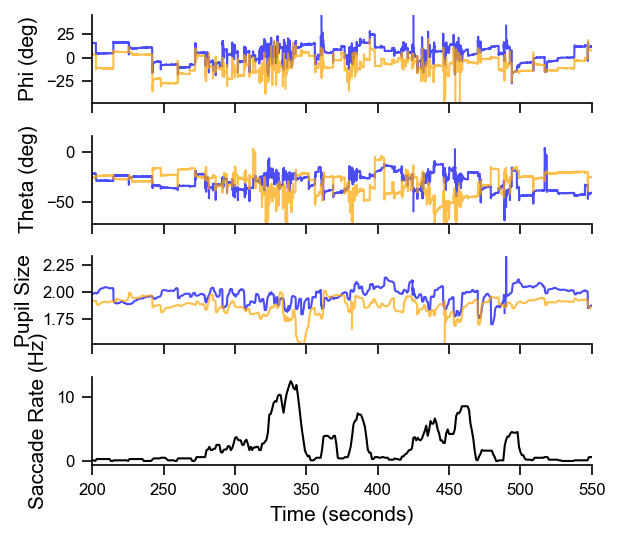

In [24]:
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import datetime
import pathlib
from matplotlib.ticker import MultipleLocator
# make pdf compatible
from matplotlib import rc
rc('pdf', fonttype=42)
from matplotlib import rcParams
# Font settings for consistency
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})

def plot_zoomed_in(start_time, end_time, traces=None, left_df=None, right_df=None, left_ms=None, right_ms=None,
                   head_movements_ms=None, state_df=None, figure_size=(15, 6), window_size=10000,
                   bin_size=1000, export_path=None, std_multiplier=4):
    """
    Plot zoomed-in eye movement data with options to display state annotations and head movements.
    This version plots the angular (phi and theta) traces (from k_phi and k_theta columns) instead of 
    the original center_x/center_y values, and automatically defines the y-axis limits around the median 
    value ± (std_multiplier * std) of the data (computed over the zoom window). This preserves extreme values 
    while zooming in on the main dynamics.
    
    Args:
        start_time (float): Start time in seconds for the zoomed-in region.
        end_time (float): End time in seconds for the zoomed-in region.
        traces (list, optional): List of data traces to plot. Available options: 
                                 ['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'].
                                 Here, 'center_x' plots phi (from k_phi) and 'center_y' plots theta (from k_theta).
        left_df (pd.DataFrame, required): Left eye data containing columns 
                                          ['k_phi', 'k_theta', 'pupil_diameter', 'ms_axis'].
        right_df (pd.DataFrame, required): Right eye data containing columns 
                                           ['k_phi', 'k_theta', 'pupil_diameter', 'ms_axis'].
        left_ms (array-like, required): Array of left eye saccade onset times in milliseconds.
        right_ms (array-like, required): Array of right eye saccade onset times in milliseconds.
        head_movements_ms (list, optional): List of head movement timestamps in milliseconds.
        state_df (pd.DataFrame, optional): DataFrame containing 'start_time', 'end_time', 'annotation' 
                                           (e.g., 'stationary', 'explores') for state annotations.
        figure_size (tuple, optional): Size of the figure. Defaults to (15, 6).
        window_size (int, optional): Rolling window size for saccade frequency calculation in milliseconds.
                                     Defaults to 10000.
        bin_size (int, optional): Bin size for saccade frequency calculation in milliseconds. Defaults to 1000.
        export_path (str, optional): File path to export the figure as a PDF.
        std_multiplier (float, optional): Multiplier for the standard deviation to set y-axis limits 
                                          around the median value. Defaults to 4.
    """
    
    # Convert ms_axis to seconds for the x-axis
    x_axis = left_df.ms_axis / 1000

    # Filter data within the specified time window
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x_axis = x_axis[mask]

    # Saccade rate calculation remains unchanged
    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        # Convert to rate (saccades per second)
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    # Initialize the plot
    num_traces = len(traces) if traces else 0
    fig, axes = plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Ensure axes is iterable

    for i, trace in enumerate(traces):
        if trace == 'center_x':
            # Get the data for phi (k_phi) from left and right eyes
            data_phi = np.concatenate([left_df['k_phi'][mask].values, right_df['k_phi'][mask].values])
            med_val = np.nanmedian(data_phi)
            std_val = np.nanstd(data_phi)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            # Plot the traces
            axes[i].plot(zoomed_x_axis, left_df['k_phi'][mask], label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_df['k_phi'][mask], label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Phi (deg)')

        elif trace == 'center_y':
            # Get the data for theta (k_theta) from left and right eyes
            data_theta = np.concatenate([left_df['k_theta'][mask].values, right_df['k_theta'][mask].values])
            med_val = np.nanmedian(data_theta)
            std_val = np.nanstd(data_theta)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            # Plot the traces
            axes[i].plot(zoomed_x_axis, left_df['k_theta'][mask], label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_df['k_theta'][mask], label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Theta (deg)')
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            # Process pupil diameter using a median filter for smoothing
            left_pupil = medfilt(left_df['pupil_diameter'], 121)[mask]
            right_pupil = medfilt(right_df['pupil_diameter'], 121)[mask]
            data_pupil = np.concatenate([left_pupil, right_pupil])
            med_val = np.nanmedian(data_pupil)
            std_val = np.nanstd(data_pupil)
            if not (np.isnan(med_val) or np.isnan(std_val)):
                y_low = med_val - std_multiplier * std_val
                y_high = med_val + std_multiplier * std_val
                axes[i].set_ylim(y_low, y_high)
            axes[i].plot(zoomed_x_axis, left_pupil, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, right_pupil, label='Right Eye', color='orange', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            axes[i].set_xlim(left=start_time, right=end_time)
            
        elif trace == 'saccade_frequency':
            axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            axes[i].set_xlim(left=start_time, right=end_time)
        
        # Add common xlabel for the last subplot
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')
    
    # Add vertical lines for head movements, if provided
    if head_movements_ms is not None:
        for ts in head_movements_ms:
            if start_time <= ts / 1000 <= end_time:
                axes[0].axvline(x=ts / 1000, color='red', linestyle='--', linewidth=1)

    # Plot state annotations, positioning lines at the top (stationary) or bottom (explores) of the y-axis
    if state_df is not None:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)
                ylims = axes[0].get_ylim()
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=ylims[1], xmin=state_start, xmax=state_end, color='red', linewidth=3)
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=ylims[0], xmin=state_start, xmax=state_end, color='green', linewidth=3)

    # Minimalistic adjustments: let Matplotlib set tick locations automatically.
    for ax in axes:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Add a legend for the traces in the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    if export_path is not None:
        print(f'exporting to {export_path}')
        plt.savefig(export_path, format='pdf')
    plt.show()


# Example usage (adjust export_path and data as needed):
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\raw_data_deg\{t}_eye_movement_trace_pv_62_b7.pdf'
plot_zoomed_in(start_time=200, end_time=550, 
               traces=['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=None,
               figure_size=(4.7, 3.7),
               export_path=export_path,
               std_multiplier=4.5)


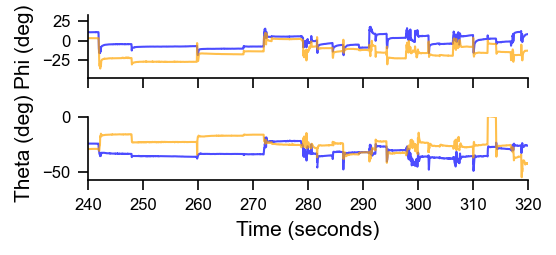

In [25]:
# Example usage with selected traces and state annotations
#export_path=block.analysis_path / 'eye_movement_z_scored_trace.pdf'
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
#export_path= fr'{str(pathlib.Path.cwd())}\figures_export\{t}_locomotion_eye_movement_z_scored_trace.pdf'
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\{t}_locomotion_eye_movement_z_scored_trace_news.pdf'
plot_zoomed_in(start_time=240, end_time=320, 
               traces=['center_x', 'center_y'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=None,
               figure_size=(4.2, 1.8),export_path=None)

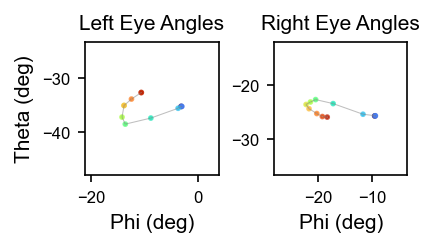

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import datetime
import pathlib

def plot_angle_mapping(start_time, end_time, left_df, right_df, figure_size=(12, 6), export_path=None, xy_span=50):
    """
    Plots 2D mappings of the angular data for the left and right eyes with a separate colorbar.
    Instead of pupil center coordinates, this function uses k_phi (horizontal angle, in degrees)
    and k_theta (vertical angle, in degrees). A fixed XY span is applied so that both subplots share
    the same axis limits.
    
    Args:
        start_time (float): Start time in seconds for the plot.
        end_time (float): End time in seconds for the plot.
        left_df (pd.DataFrame): Left eye dataframe with columns 'ms_axis', 'k_phi', 'k_theta'.
        right_df (pd.DataFrame): Right eye dataframe with columns 'ms_axis', 'k_phi', 'k_theta'.
        figure_size (tuple): Overall figure size (width, height).
        export_path (str or None): If provided, the plot will be saved (the function will modify the filename).
        xy_span (float): The total width and height of the X and Y axes (in degrees).
    """
    # Filter data by time (convert ms_axis to seconds)
    mask_left = (left_df['ms_axis'] / 1000 >= start_time) & (left_df['ms_axis'] / 1000 <= end_time)
    mask_right = (right_df['ms_axis'] / 1000 >= start_time) & (right_df['ms_axis'] / 1000 <= end_time)

    # Extract times and angular data
    times_left = left_df['ms_axis'][mask_left] / 1000
    times_right = right_df['ms_axis'][mask_right] / 1000
    phi_left = left_df['k_phi'][mask_left]
    theta_left = left_df['k_theta'][mask_left]
    phi_right = right_df['k_phi'][mask_right]
    theta_right = right_df['k_theta'][mask_right]

    # Normalize times for color mapping
    norm = Normalize(vmin=start_time, vmax=end_time)
    cmap = plt.cm.turbo

    # Compute midpoints for each eye's angle data
    phi_left_mid = (phi_left.max() + phi_left.min()) / 2
    theta_left_mid = (theta_left.max() + theta_left.min()) / 2
    phi_right_mid = (phi_right.max() + phi_right.min()) / 2
    theta_right_mid = (theta_right.max() + theta_right.min()) / 2

    # Set identical axis limits based on a user-defined span
    half_span = xy_span / 2
    x_lim_left = (phi_left_mid - half_span, phi_left_mid + half_span)
    y_lim_left = (theta_left_mid - half_span, theta_left_mid + half_span)
    x_lim_right = (phi_right_mid - half_span, phi_right_mid + half_span)
    y_lim_right = (theta_right_mid - half_span, theta_right_mid + half_span)

    # Create figure with two subplots (left and right eye)
    fig, axes = plt.subplots(1, 2, figsize=figure_size, dpi=150, constrained_layout=True)
    
    # Scatter plot with time color mapping and connecting trajectory for the left eye
    scatter_left = axes[0].scatter(phi_left, theta_left, c=times_left, cmap=cmap, norm=norm, s=3, alpha=0.7)
    axes[0].plot(phi_left, theta_left, color='gray', alpha=0.5, linewidth=0.5)
    axes[0].set_title('Left Eye Angles', fontsize=10)
    axes[0].set_xlim(x_lim_left)
    axes[0].set_ylim(y_lim_left)
    
    # Scatter plot with time color mapping and connecting trajectory for the right eye
    scatter_right = axes[1].scatter(phi_right, theta_right, c=times_right, cmap=cmap, norm=norm, s=3, alpha=0.7)
    axes[1].plot(phi_right, theta_right, color='gray', alpha=0.5, linewidth=0.5)
    axes[1].set_title('Right Eye Angles', fontsize=10)
    axes[1].set_xlim(x_lim_right)
    axes[1].set_ylim(y_lim_right)
    
    # Set common labels and ensure equal axis proportions
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_ylabel('Theta (deg)', fontsize=10)
        ax.set_xlabel('Phi (deg)', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
    
    # Export the main plot if export_path is provided
    if export_path is not None:
        main_plot_path = export_path.replace('.pdf', '_main.pdf')
        fig.savefig(main_plot_path, format='pdf')
        print(f"Main plot exported to {main_plot_path}")
    
    plt.show()
    
    # -------- CREATE SEPARATE COLORBAR --------
    cbar_fig, cbar_ax = plt.subplots(figsize=(0.2, figure_size[1]), dpi=150)
    tick_position = np.linspace(start_time, end_time, num=3)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = cbar_fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=tick_position)
    cbar.set_label('Time (s)', fontsize=10)
    cbar.ax.set_yticklabels([f"{t:.1f}" for t in tick_position])
    cbar.ax.tick_params(labelsize=8, which='both')
    
    if export_path is not None:
        colorbar_path = export_path.replace('.pdf', '_colorbar.pdf')
        cbar_fig.savefig(colorbar_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar exported to {colorbar_path}")
    
    plt.close(cbar_fig)

t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 284.4
e_t = 284.6
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_angle_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.7,1.7),
    xy_span=25,
    export_path=None)

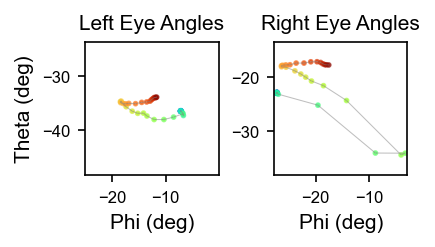

In [27]:
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 259.5
e_t = 260.2
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_angle_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.7,1.7),
    xy_span=25,
    export_path=None)

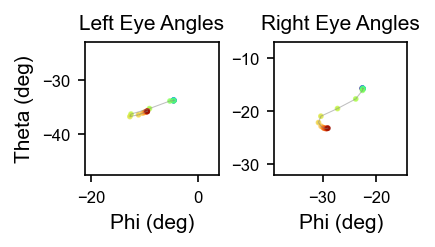

In [28]:
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 247.7
e_t = 248.1
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_angle_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.7,1.7),
    xy_span=25,
    export_path=None)